In [42]:
import csv
from datetime import datetime, timedelta

# Read the CSV file
data = []
with open('check1.csv', mode='r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        row['datetime'] = datetime.strptime(row['Datetime'], '%Y-%m-%d %H:%M:%S%z')
        row['open'] = float(row['Open'])
        row['high'] = float(row['High'])
        row['low'] = float(row['Low'])
        row['close'] = float(row['Close'])
        row['volume'] = float(row['Volume'])
        row['prediction'] = int(row['Prediction'])
        data.append(row)

# Initialize variables for backtesting
cash = 10000
position = 0
equity_curve = []

# Helper function to find the index of a future datetime
def find_future_index(current_index, minutes_ahead):
    future_time = data[current_index]['datetime'] + timedelta(minutes=minutes_ahead)
    for i in range(current_index + 1, len(data)):
        if data[i]['datetime'] >= future_time:
            return i
    return len(data) - 1

# Backtesting loop
for i in range(len(data)):
    prediction = data[i]['prediction']
    current_price = data[i]['close']

    if position == 0:  # No open position
        if prediction // 10 == 1:  # Downtrend signal
            num_candles = prediction % 10
            future_index = find_future_index(i, num_candles)
            future_price = data[future_index]['close']
            position = -1
            cash += (current_price - future_price) * position
        elif prediction // 10 == 2:  # Uptrend signal
            num_candles = prediction % 10
            future_index = find_future_index(i, num_candles)
            future_price = data[future_index]['close']
            position = 1
            cash += (future_price - current_price) * position
    else:
        position = 0

    equity_curve.append(cash)

# Calculate performance metrics
initial_cash = 10000
final_cash = cash
total_return = (final_cash - initial_cash) / initial_cash * 100

# Print results
print(f"Initial Cash: ${initial_cash:.2f}")
print(f"Final Cash: ${final_cash:.2f}")
print(f"Total Return: {total_return:.2f}%")

# Plot the equity curve (optional, requires matplotlib)
try:
    import matplotlib.pyplot as plt

    plt.plot(equity_curve)
    plt.xlabel('Time')
    plt.ylabel('Equity')
    plt.title('Equity Curve')
    plt.show()
except ImportError:
    print("Install matplotlib to see the equity curve plot.")


Initial Cash: $10000.00
Final Cash: $10000.16
Total Return: 0.00%


In [9]:
import pandas as pd

# Load the CSV
data = pd.read_csv('check1.csv')

# Assume the CSV has columns: 'date', 'price', 'prediction'

# Initial cash
initial_cash = 10000  # Example initial cash amount
cash = initial_cash
position = 0  # 1 means we hold a position, 0 means we don't
buy_price = 0
trade_log = []
wins = 0
losses = 0

# Iterate through the rows
for i in range(len(data) - 1):
    if data.loc[i, 'Prediction'] == 1 and position == 0:
        # Buy signal
        position = 1
        buy_price = data.loc[i+1, 'Close']  # Buy at the next candle's price
        trade_log.append(f"Buy at {buy_price} on {data.loc[i+1, 'Datetime']}")
    elif data.loc[i, 'Prediction'] == 0 and position == 1:
        # Sell signal
        position = 0
        sell_price = data.loc[i+1, 'Close']  # Sell at the next candle's price
        profit = sell_price - buy_price
        cash += profit
        trade_log.append(f"Sell at {sell_price} on {data.loc[i+1, 'Datetime']} Profit: {profit}")
        if profit > 0:
            wins += 1
        else:
            losses += 1

# If we end up holding a position at the end of the data, sell it
if position == 1:
    sell_price = data.iloc[-1]['Close']
    profit = sell_price - buy_price
    cash += profit
    trade_log.append(f"Sell at {sell_price} on {data.iloc[-1]['Datetime']} Profit: {profit}")
    if profit > 0:
        wins += 1
    else:
        losses += 1

# Calculate performance metrics
total_trades = wins + losses
win_rate = (wins / total_trades) * 100 if total_trades > 0 else 0
return_percentage = ((cash - initial_cash) / initial_cash) * 100
final_portfolio_value = cash

# Print the trade log and performance metrics
for log in trade_log:
    print(log)
print(f"Total PnL: {cash - initial_cash}")
print(f"Return Percentage: {return_percentage}%")
print(f"Win Rate: {win_rate}%")
print(f"Final Portfolio Value: {final_portfolio_value}")

# Save trade log to CSV if needed
trade_log_df = pd.DataFrame(trade_log, columns=["Trade"])



Buy at 25.78 on 2024-07-13 12:06:00+00:00
Sell at 25.75 on 2024-07-13 12:07:00+00:00 Profit: -0.030000000000001137
Buy at 25.75 on 2024-07-13 12:08:00+00:00
Sell at 25.73 on 2024-07-13 12:10:00+00:00 Profit: -0.019999999999999574
Buy at 25.74 on 2024-07-13 12:11:00+00:00
Sell at 25.74 on 2024-07-13 12:14:00+00:00 Profit: 0.0
Buy at 25.74 on 2024-07-13 12:15:00+00:00
Sell at 25.82 on 2024-07-13 12:25:00+00:00 Profit: 0.08000000000000185
Buy at 25.87 on 2024-07-13 12:26:00+00:00
Sell at 25.86 on 2024-07-13 12:27:00+00:00 Profit: -0.010000000000001563
Buy at 25.95 on 2024-07-13 12:28:00+00:00
Sell at 25.93 on 2024-07-13 12:29:00+00:00 Profit: -0.019999999999999574
Buy at 25.93 on 2024-07-13 12:30:00+00:00
Sell at 25.9 on 2024-07-13 12:31:00+00:00 Profit: -0.030000000000001137
Buy at 25.9 on 2024-07-13 12:32:00+00:00
Sell at 25.89 on 2024-07-13 12:33:00+00:00 Profit: -0.00999999999999801
Buy at 25.9 on 2024-07-13 12:34:00+00:00
Sell at 25.89 on 2024-07-13 12:36:00+00:00 Profit: -0.00999999

In [2]:
from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
client = Client()

In [7]:
import pandas as pd
klines = client.get_historical_klines("AVAXUSDT", Client.KLINE_INTERVAL_1MINUTE, "10 January, 2024", "30 January, 2024")

columns = [
            'Open time', 'Open', 'High', 'Low', 'Close', 'Volume1',
            'Close time', 'Volume', 'Adj Close',
            'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'
        ]

        # Create a DataFrame
df = pd.DataFrame(klines, columns=columns)

        # Drop unnecessary columns
df = df.drop(['Close time', 'Volume1',
                      'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'], axis='columns')

        # Convert timestamp columns to datetime
df['Datetime'] = pd.to_datetime(df['Open time'], unit='ms')
df = df.drop(['Open time'], axis='columns')
df.set_index('Datetime', inplace=True)
df.index = df.index.tz_localize('UTC')  # Localize to UTC

        # Convert specific columns to desired data types
df = df.astype({
            'Open': float,
            'High': float,
            'Low': float,
            'Close': float,
            'Adj Close': int,
            'Volume': float
        })

df['Volume'] = df['Volume'].astype(int)

In [12]:
df

Open   High    Low  Close  Volume  Adj Close
Datetime                                                                
2024-03-10 00:00:00+00:00  42.92  43.00  42.91  42.93  180253        184
2024-03-10 00:01:00+00:00  42.93  42.95  42.91  42.91   45945         75
2024-03-10 00:02:00+00:00  42.92  42.92  42.84  42.85   46286         79
2024-03-10 00:03:00+00:00  42.85  42.89  42.82  42.88   82223        104
2024-03-10 00:04:00+00:00  42.89  42.89  42.84  42.84   23432         45
...                          ...    ...    ...    ...     ...        ...
2024-03-29 23:56:00+00:00  53.35  53.37  53.35  53.37   39050         52
2024-03-29 23:57:00+00:00  53.37  53.37  53.34  53.34   19691         68
2024-03-29 23:58:00+00:00  53.35  53.35  53.32  53.33   43474        123
2024-03-29 23:59:00+00:00  53.34  53.34  53.32  53.33   57927         78
2024-03-30 00:00:00+00:00  53.32  53.37  53.32  53.33   30136         86

[28801 rows x 6 columns]

In [8]:
df.to_csv('TATA.csv')

In [11]:
df1 = pd.read_csv('btcusd.csv',index_col='Datetime')
df2 = pd.read_csv('artifacts/predictions_new.csv',index_col='Datetime')

In [13]:
combined_df = pd.concat([df1, df2])
combined_df = combined_df[~combined_df.index.duplicated(keep='first')]
combined_df.to_csv('deepbacktest.csv')

Buying at 28.58 on 2024-07-29 11:57:00+00:00
Selling at 28.56 on 2024-07-29 11:59:00+00:00 with profit -0.019999999999999574
Buying at 28.56 on 2024-07-29 11:59:00+00:00
Selling at 28.59 on 2024-07-29 12:01:00+00:00 with profit 0.030000000000001137
Buying at 28.58 on 2024-07-29 12:00:00+00:00
Selling at 28.56 on 2024-07-29 12:02:00+00:00 with profit -0.019999999999999574
Buying at 28.57 on 2024-07-29 12:03:00+00:00
Selling at 28.54 on 2024-07-29 12:06:00+00:00 with profit -0.030000000000001137
Buying at 28.56 on 2024-07-29 12:04:00+00:00
Selling at 28.52 on 2024-07-29 12:07:00+00:00 with profit -0.03999999999999915
Buying at 28.55 on 2024-07-29 12:05:00+00:00
Selling at 28.52 on 2024-07-29 12:07:00+00:00 with profit -0.030000000000001137
Buying at 28.54 on 2024-07-29 12:06:00+00:00
Selling at 28.54 on 2024-07-29 12:09:00+00:00 with profit 0.0
Buying at 28.52 on 2024-07-29 12:07:00+00:00
Selling at 28.54 on 2024-07-29 12:09:00+00:00 with profit 0.019999999999999574
Buying at 28.55 on 20

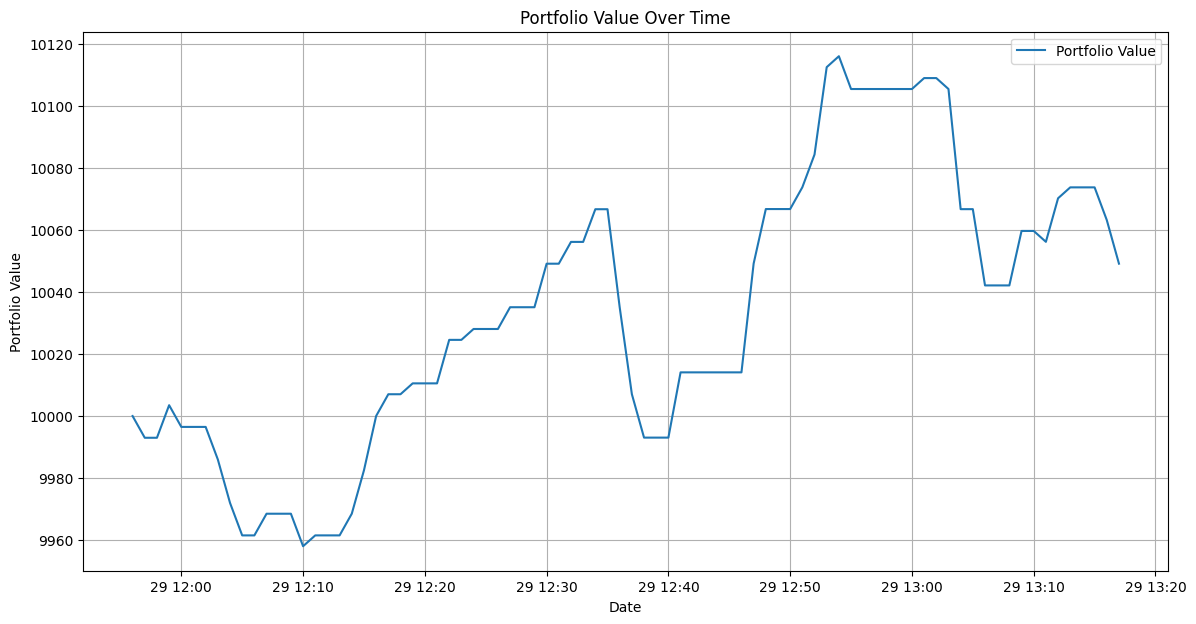

In [13]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Load historical data
#data = pd.read_csv("deepbacktest.csv", index_col='Datetime', parse_dates=True)
data = pd.read_csv("/home/nitin/Downloads/Project/artifacts/predictions_new.csv", index_col='Datetime', parse_dates=True)

data = data.iloc[-82:]

# Initialize variables for backtesting
initial_cash = 10000  # Starting cash
cash = initial_cash
position = 0  # Number of shares held
hold_period = 2  # Number of candles to hold after a buy or sell

# List to track portfolio value over time and trades
portfolio_values = []
trades = []
buy_signal_profits = {signal: 0 for signal in range(6)}  # To track profit for each buy signal

# Loop through the data
for i in range(len(data)):
    prediction = data['Prediction'].iloc[i]
    close_price = data['Close'].iloc[i]
    
    if prediction == 0 and position > 0:  # Sell signal
        sell_price = close_price
        cash = position * sell_price
        position = 0
        print(f"Selling at {sell_price} on {data.index[i]}")
        trades.append(('Sell', sell_price, data.index[i]))
        
        # Buy after hold_period candles if within bounds
        buy_index = i + hold_period
        if buy_index < len(data):
            buy_price = data['Close'].iloc[buy_index]
            position = cash / buy_price
            cash = 0
            print(f"Buying at {buy_price} on {data.index[buy_index]}")
            trades.append(('Buy', buy_price, data.index[buy_index]))
    
    elif prediction in [ 2, 3, 4, 5] and cash > 0:  # Buy signals
        buy_price = close_price
        position = cash / buy_price
        cash = 0
        buy_signal = prediction  # Store the buy signal type
        print(f"Buying at {buy_price} on {data.index[i]}")
        trades.append(('Buy', buy_price, data.index[i], buy_signal))
        
        # Sell after hold_period + (prediction - 2) candles if within bounds
        sell_index = i + hold_period + (prediction - 2)
        if sell_index < len(data):
            sell_price = data['Close'].iloc[sell_index]
            cash = position * sell_price
            position = 0
            profit = sell_price - buy_price  # Calculate profit
            buy_signal_profits[buy_signal] += profit  # Track profit for the buy signal
            print(f"Selling at {sell_price} on {data.index[sell_index]} with profit {profit}")
            trades.append(('Sell', sell_price, data.index[sell_index]))
    
    # Calculate current portfolio value
    current_value = cash + (position * close_price)
    portfolio_values.append(current_value)

# Final portfolio value
final_value = cash + (position * data['Close'].iloc[-1])
print(f"Final portfolio value: {final_value}")
print(f"Net profit: {final_value - initial_cash}")

# Convert portfolio values list to a pandas Series
portfolio_values = pd.Series(portfolio_values, index=data.index[:len(portfolio_values)])

# Calculate cumulative returns
cumulative_returns = portfolio_values.pct_change().add(1).cumprod().sub(1)

# Calculate drawdown
running_max = portfolio_values.cummax()
drawdown = (portfolio_values - running_max) / running_max

# Calculate volatility
volatility = portfolio_values.pct_change().std() * (252 ** 0.5)  # Annualized volatility assuming 252 trading days

# Calculate additional metrics
duration = data.index[-1] - data.index[0]
exposure_time = len(data[pd.notnull(portfolio_values)]) / len(data) * 100
buy_and_hold_return = (data['Close'].iloc[-1] / data['Close'].iloc[0] - 1) * 100
annual_return = ((final_value / initial_cash) ** (252 / len(data)) - 1) * 100
max_drawdown = drawdown.min() * 100
avg_drawdown = drawdown.mean() * 100
max_drawdown_duration = (drawdown[drawdown == drawdown.min()].index[0] - drawdown.cummin().idxmin()).days
avg_drawdown_duration = drawdown[drawdown < 0].mean()
win_rate = len([trade for trade in trades if trade[0] == 'Sell' and trade[1] > trades[trades.index(trade) - 1][1]]) / len([trade for trade in trades if trade[0] == 'Sell']) * 100
best_trade = max([trade[1] - trades[trades.index(trade) - 1][1] for trade in trades if trade[0] == 'Sell'])
worst_trade = min([trade[1] - trades[trades.index(trade) - 1][1] for trade in trades if trade[0] == 'Sell'])
avg_trade = sum([trade[1] - trades[trades.index(trade) - 1][1] for trade in trades if trade[0] == 'Sell']) / len([trade for trade in trades if trade[0] == 'Sell'])
profit_factor = sum([trade[1] - trades[trades.index(trade) - 1][1] for trade in trades if trade[0] == 'Sell' and trade[1] > trades[trades.index(trade) - 1][1]]) / -sum([trade[1] - trades[trades.index(trade) - 1][1] for trade in trades if trade[0] == 'Sell' and trade[1] < trades[trades.index(trade) - 1][1]])
expectancy = avg_trade / initial_cash * 100
sqn = (avg_trade / volatility) * (len(trades) ** 0.5)

# Calculate the number of days of trades
number_of_trading_days = (data.index[-1] - data.index[0]).total_seconds() / 3600

# Plot the portfolio value over time
plt.figure(figsize=(14, 7))
plt.plot(portfolio_values, label='Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)

backtest_report = {
    'Initial Cash': initial_cash,
    'Final Portfolio Value': final_value,
    'Net Profit': final_value - initial_cash,
    'Cumulative Returns': cumulative_returns.iloc[-1],
    'Max Drawdown': max_drawdown,
    'Avg. Drawdown': avg_drawdown,
    'Max Drawdown Duration': max_drawdown_duration,
    'Avg. Drawdown Duration': avg_drawdown_duration,
    'Annualized Volatility': volatility,
    'Exposure Time [%]': exposure_time,
    'Return [%]': (final_value - initial_cash) / initial_cash * 100,
    'Buy & Hold Return [%]': buy_and_hold_return,
    'Return (Ann.) [%]': annual_return,
    'Sharpe Ratio': 0,  # Placeholder for now
    'Sortino Ratio': 0,  # Placeholder for now
    'Calmar Ratio': 0,  # Placeholder for now
    'Win Rate [%]': win_rate,
    'Best Trade [%]': best_trade / initial_cash * 100,
    'Worst Trade [%]': worst_trade / initial_cash * 100,
    'Avg. Trade [%]': avg_trade / initial_cash * 100,
    'Max. Trade Duration': 0,  # Placeholder for now
    'Avg. Trade Duration': 0,  # Placeholder for now
    'Profit Factor': profit_factor,
    'Expectancy [%]': expectancy,
    'SQN': sqn,
    'Number of Trading Hours': number_of_trading_days
}

# Add the profits generated by each buy signal to the report
for signal, profit in buy_signal_profits.items():
    backtest_report[f'Profit for Buy Signal {signal} [%]'] = profit

# Save the plot and the metrics in a PDF
with PdfPages('backtest_report.pdf') as pdf:
    pdf.savefig()  # Save the current figure
    
    # Create a new figure for the metrics
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.axis('off')
    table_data = list(backtest_report.items())
    table = ax.table(cellText=table_data, colLabels=['Metric', 'Value'], loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    pdf.savefig()  # Save the table figure
    plt.close()

# Add metrics to the dataframe
data['Portfolio Value'] = portfolio_values
data['Cumulative Returns'] = cumulative_returns
data['Drawdown'] = drawdown

# Save the backtest result to a CSV
counter = 1
while True:
    filename = os.path.join('backtest', f'backtesting_{counter}.csv')
    if not os.path.exists(filename):
        break
    counter += 1

data.to_csv(filename)

# Output results

for key, value in backtest_report.items():
    print(f"{key}: {value}")


In [16]:
import pandas as pd
df = pd.read_csv('artifacts/df_cleaned.csv')

In [17]:
unique_values = {col: df[col].unique() for col in df.columns}

# Print unique values
for col, values in unique_values.items():
    print(f"Column '{col}': {values}")

Column 'Year': [2024]
Column 'Month': [5]
Column 'Day': [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25]
Column 'Hour': [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Column 'Minute': [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Column 'EMASignal': [0 2 1]
Column 'isPivot': [0 2 1]
Column 'CHOCH_pattern_detected': [0 2 1]
Column 'fibonacci_signal': [0 1 2]
Column 'LBD_detected': [0 1]
Column 'LBH_detected': [0 1]
Column 'SR_signal': [0 2 1]
Column 'isBreakOut': [0 1]
Column 'candlestick_signal': [0 1 2]
Column 'Trend': [0 2 1]
Column 'signal1': [0 1 2]
Column 'buy_signal': [0 1]
Column 'sell_signal': [0 1]
Column 'BB_signal': [0 2 1]
Column 'fractal_high': [0]
Column 'fractal_low': [0]
Column 'fractals_high': [0]
Column 'fractals_low': [0]
Column 'buy_signal1': [0 1]
Column 'Fractal_signal': [0 1 2]
Column 

In [15]:
df = df['candlestick_signal'].replace(1,0)
df = df['Signal1'].replace(1,0)
df.to_csv('artifacts/df_cleaned.csv')

KeyError: 'candlestick_signal'

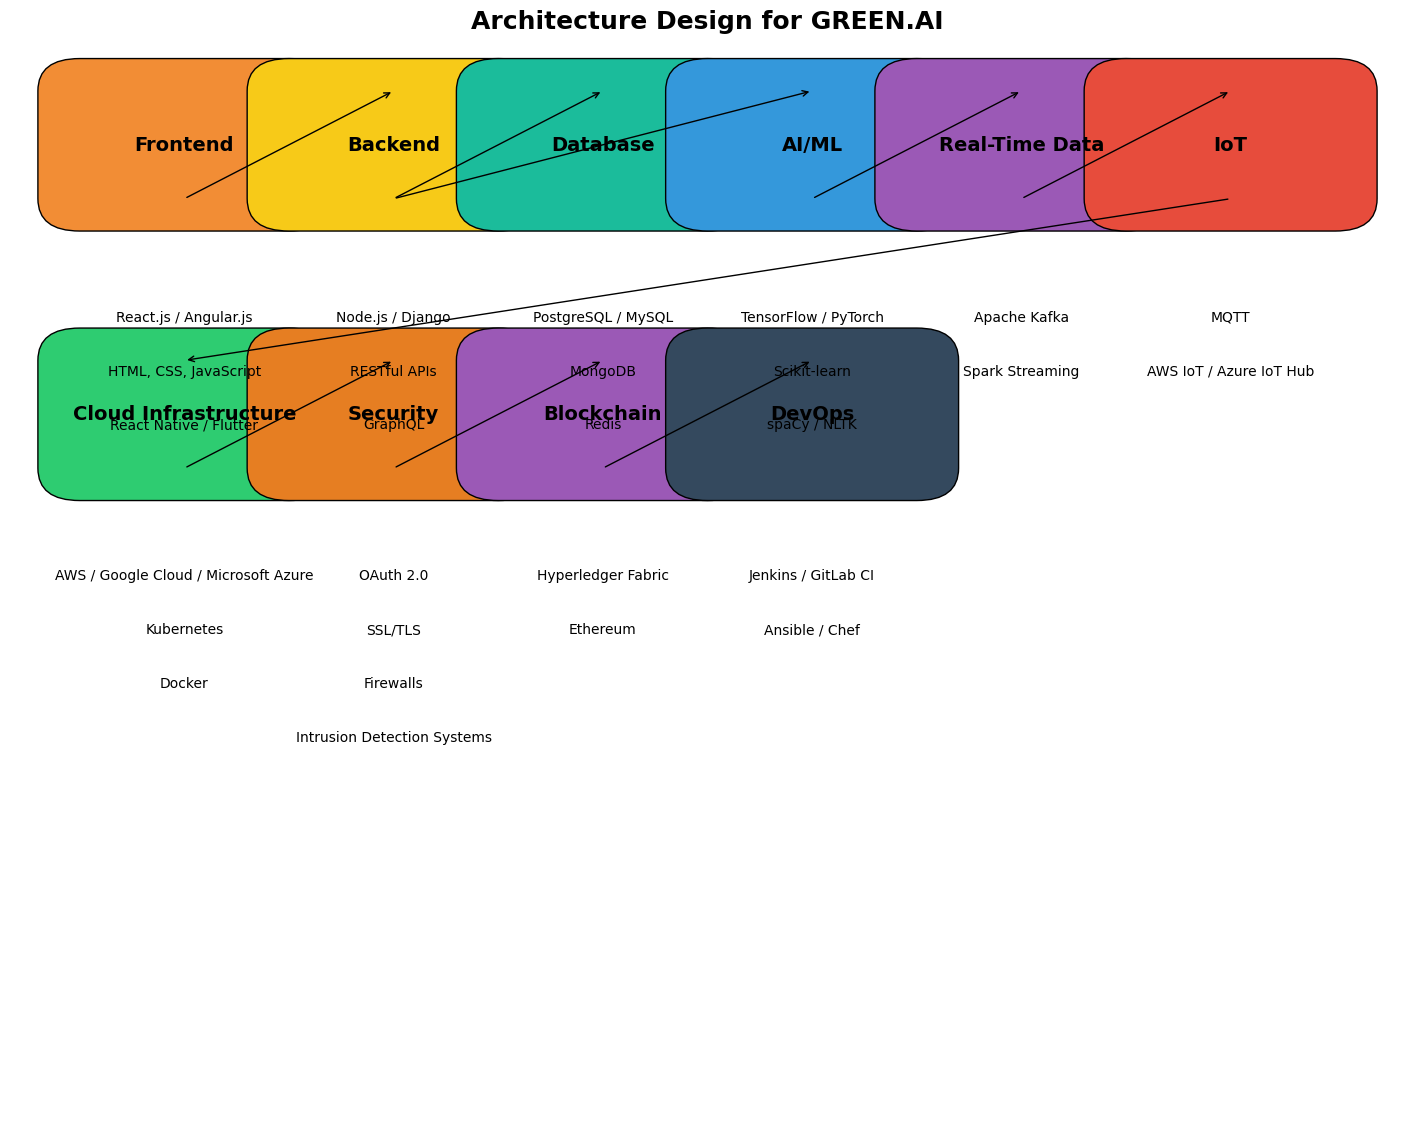

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create a figure and axis
fig, ax = plt.subplots(figsize=(18, 14))

# Define colors for different layers
colors = {
    "Frontend": "#F28D35",
    "Backend": "#F7CA18",
    "Database": "#1BBC9B",
    "AI/ML": "#3498DB",
    "Real-Time Data": "#9B59B6",
    "IoT": "#E74C3C",
    "Cloud Infrastructure": "#2ECC71",
    "Security": "#E67E22",
    "Blockchain": "#9B59B6",
    "DevOps": "#34495E"
}

# Define positions for the blocks
positions = {
    "Frontend": (0.05, 0.85),
    "Backend": (0.2, 0.85),
    "Database": (0.35, 0.85),
    "AI/ML": (0.5, 0.85),
    "Real-Time Data": (0.65, 0.85),
    "IoT": (0.8, 0.85),
    "Cloud Infrastructure": (0.05, 0.6),
    "Security": (0.2, 0.6),
    "Blockchain": (0.35, 0.6),
    "DevOps": (0.5, 0.6)
}

# Define sizes for the blocks
block_width = 0.15
block_height = 0.1

# Draw the blocks with rounded edges and corresponding colors
for key, (x, y) in positions.items():
    color = colors[key]
    ax.add_patch(patches.FancyBboxPatch((x, y), block_width, block_height, boxstyle="round,pad=0.03", edgecolor="black", facecolor=color))
    ax.text(x + block_width / 2, y + block_height / 2, key, ha='center', va='center', fontsize=14, color="black", weight='bold')

# Define positions for technologies within each block
tech_positions = {
    "Frontend": (0.05, 0.74, ["React.js / Angular.js", "HTML, CSS, JavaScript", "React Native / Flutter"]),
    "Backend": (0.2, 0.74, ["Node.js / Django", "RESTful APIs", "GraphQL"]),
    "Database": (0.35, 0.74, ["PostgreSQL / MySQL", "MongoDB", "Redis"]),
    "AI/ML": (0.5, 0.74, ["TensorFlow / PyTorch", "Scikit-learn", "spaCy / NLTK"]),
    "Real-Time Data": (0.65, 0.74, ["Apache Kafka", "Spark Streaming"]),
    "IoT": (0.8, 0.74, ["MQTT", "AWS IoT / Azure IoT Hub"]),
    "Cloud Infrastructure": (0.05, 0.5, ["AWS / Google Cloud / Microsoft Azure", "Kubernetes", "Docker"]),
    "Security": (0.2, 0.5, ["OAuth 2.0", "SSL/TLS", "Firewalls", "Intrusion Detection Systems"]),
    "Blockchain": (0.35, 0.5, ["Hyperledger Fabric", "Ethereum"]),
    "DevOps": (0.5, 0.5, ["Jenkins / GitLab CI", "Ansible / Chef"])
}

# Draw technologies within each block
for key, (x, y, techs) in tech_positions.items():
    for i, tech in enumerate(techs):
        ax.text(x + block_width / 2, y - i * 0.05, tech, ha='center', va='center', fontsize=10, color="black")

# Define connections
connections = [
    ("Frontend", "Backend"),
    ("Backend", "Database"),
    ("Backend", "AI/ML"),
    ("AI/ML", "Real-Time Data"),
    ("Real-Time Data", "IoT"),
    ("IoT", "Cloud Infrastructure"),
    ("Cloud Infrastructure", "Security"),
    ("Security", "Blockchain"),
    ("Blockchain", "DevOps")
]

# Draw connections as arrows
for start, end in connections:
    start_pos = positions[start]
    end_pos = positions[end]
    ax.annotate('', xy=(end_pos[0] + block_width / 2, end_pos[1] + block_height), 
                xytext=(start_pos[0] + block_width / 2, start_pos[1]),
                arrowprops=dict(arrowstyle="->", color='black'))

# Add title
plt.title('Architecture Design for GREEN.AI', fontsize=18, weight='bold')

# Hide axes
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

# Display the diagram
plt.show()


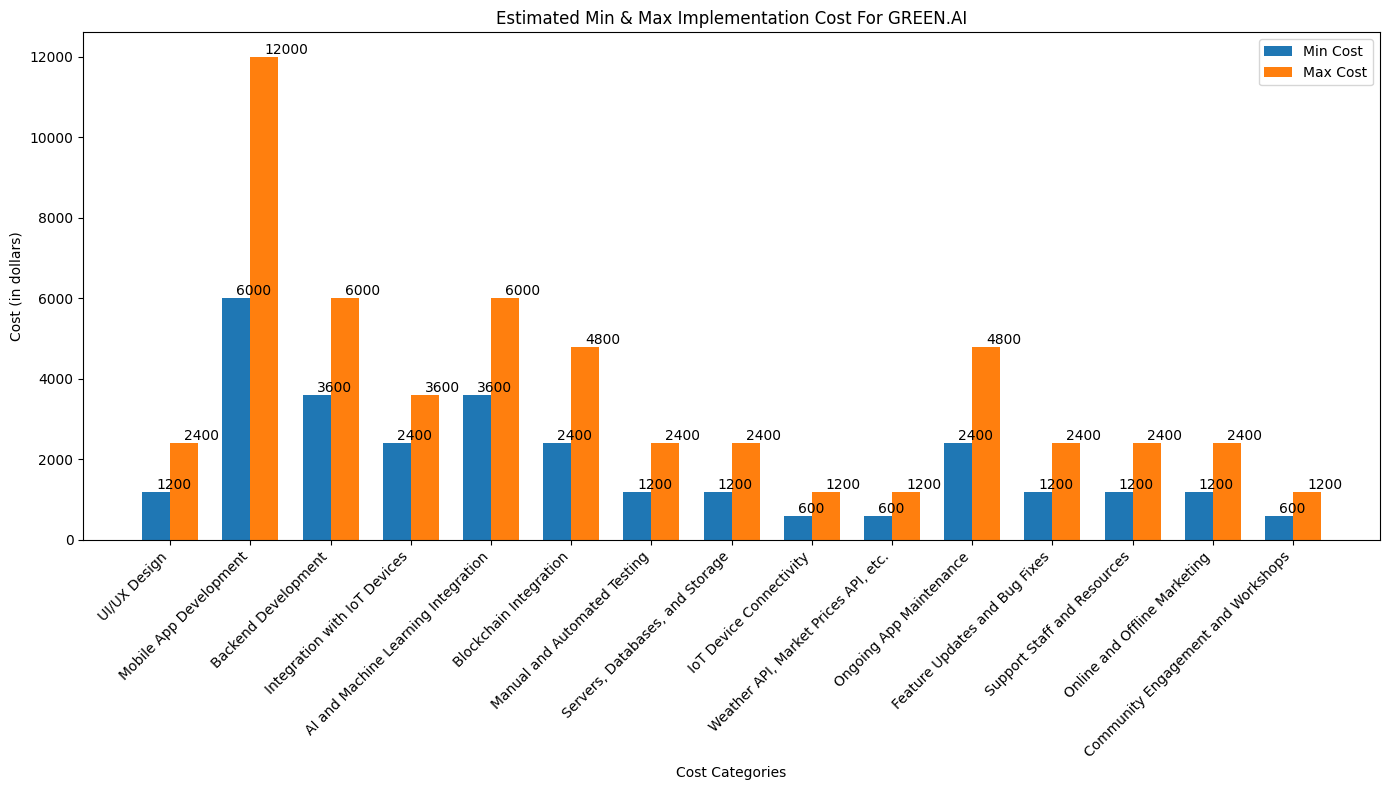

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = [
    'UI/UX Design',
    'Mobile App Development',
    'Backend Development',
    'Integration with IoT Devices',
    'AI and Machine Learning Integration',
    'Blockchain Integration',
    'Manual and Automated Testing',
    'Servers, Databases, and Storage',
    'IoT Device Connectivity',
    'Weather API, Market Prices API, etc.',
    'Ongoing App Maintenance',
    'Feature Updates and Bug Fixes',
    'Support Staff and Resources',
    'Online and Offline Marketing',
    'Community Engagement and Workshops'
]

# Costs (in dollars)
min_costs = [
    1200, 6000, 3600, 2400, 3600, 2400, 1200, 1200, 600, 600, 2400, 1200, 1200, 1200, 600
]
max_costs = [
    2400, 12000, 6000, 3600, 6000, 4800, 2400, 2400, 1200, 1200, 4800, 2400, 2400, 2400, 1200
]

# Indices for x-axis
x = np.arange(len(categories))

# Bar width
width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))

# Plotting the bars
bars1 = ax.bar(x - width/2, min_costs, width, label='Min Cost')
bars2 = ax.bar(x + width/2, max_costs, width, label='Max Cost')

# Adding labels
ax.set_xlabel('Cost Categories')
ax.set_ylabel('Cost (in dollars)')
ax.set_title('Estimated Min & Max Implementation Cost For GREEN.AI')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.legend()

# Adding value labels on top of the bars
for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')  # va: vertical alignment
for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')  # va: vertical alignment

fig.tight_layout()

plt.show()


In [ ]:
df1 = pd.read_csv()